# 1.Implied Volatilities

### Valuation of European call option in BSM model

- S0:float,initial stock/index level
- K:float,strike price
- T:float,maturity date(in year fractions)
- r:float,constant risk-free short rate
- sigma:float,volatility factor in diffusion term

In [2]:
from math import log,sqrt,exp
from scipy import stats

In [3]:
#value: present value of the European call option
def bsm_call_value(S0,K,T,r,sigma):
    S0=float(S0)
    d1=(log(S0/K)+(r+0.5*sigma**2)*T)/(sigma*sqrt(T))
    d2=(log(S0/K)+(r-0.5*sigma**2)*T)/(sigma*sqrt(T))
    value=(S0*stats.norm.cdf(d1,0.0,1.0)-K*exp(-r*T)*stats.norm.cdf(d2,0.0,1.0))
    return value

In [4]:
#vega : float partial derivative of BSM formula with respect to sigma, i.e. Vega
def bsm_vega(S0,K,T,r,sigma):
    S0=float(S0)
    d1=(log(S0/K)+(r+0.5*sigma**2)*T)/(sigma*sqrt(T))
    vega=S0*stats.norm.cdf(d1,0.0,1.0)*sqrt(T)
    return vega

In [6]:
#Implied volatility of European call option in BSM model
def bsm_call_imp_vol(S0,K,T,r,C0,sigma_est,it=100):
    # it:number of iterations
    # sigma_est:estimate of impl.volatility
    for i in range(it):
        sigma_est-=((bsm_call_value(S0,K,T,r,sigma_est))-C0)/bsm_vega(S0,K,T,r,sigma_est)
    return sigma_est

In [10]:
import pandas as pd

In [15]:
h5=pd.HDFStore('source/vstoxx_data_31032014.h5','r')
futures_data=h5['futures_data']
options_data=h5['options_data']
h5.close()

In [18]:
futures_data

,DATE,EXP_YEAR,EXP_MONTH,PRICE,MATURITY,TTM
496,2014-03-31,2014,4,17.85,2014-04-18,0.049
497,2014-03-31,2014,5,19.55,2014-05-16,0.126
498,2014-03-31,2014,6,19.95,2014-06-20,0.222
499,2014-03-31,2014,7,20.40,2014-07-18,0.299
500,2014-03-31,2014,8,20.70,2014-08-15,0.375
501,2014-03-31,2014,9,20.95,2014-09-19,0.471
502,2014-03-31,2014,10,21.05,2014-10-17,0.548
503,2014-03-31,2014,11,21.25,2014-11-21,0.644


In [20]:
options_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 395 entries, 46170 to 46564
Data columns (total 8 columns):
DATE         395 non-null datetime64[ns]
EXP_YEAR     395 non-null int64
EXP_MONTH    395 non-null int64
TYPE         395 non-null object
STRIKE       395 non-null float64
PRICE        395 non-null float64
MATURITY     395 non-null datetime64[ns]
TTM          395 non-null float64
dtypes: datetime64[ns](2), float64(3), int64(2), object(1)
memory usage: 27.8+ KB


In [21]:
options_data['IMP_VOL']=0.0

In [22]:
V0=17.6639
r=0.01
tol=0.5#tolerance level for moneyness

In [25]:
for option in options_data.index:
    forward=futures_data[futures_data['MATURITY']==options_data.loc[option]['MATURITY']]['PRICE'].values[0]
    if(forward*(1-tol)<options_data.loc[option]['STRIKE']<forward*(1+tol)):
        imp_vol=bsm_call_imp_vol(V0,options_data.loc[option]['STRIKE'],options_data.loc[option]['TTM']
                                 ,r,options_data.loc[option]['PRICE'],sigma_est=2.,it=100)
        options_data['IMP_VOL'].loc[option]=imp_vol

In [27]:
plot_data=options_data[options_data['IMP_VOL']>0]

In [28]:
maturities=sorted(set(options_data['MATURITY']))

/Users/qinkevin/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


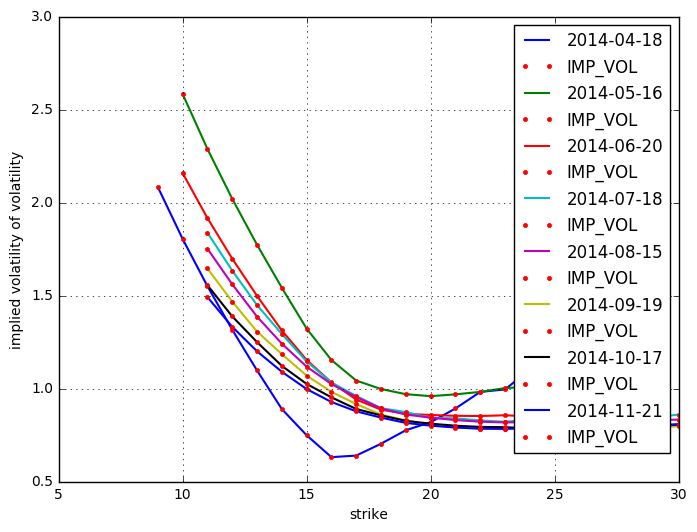

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(8,6))
for maturity in maturities:
    data=plot_data[options_data['MATURITY']==maturity]
    plt.plot(data['STRIKE'],data['IMP_VOL'],label=maturity.date(),lw=1.5)
    plt.plot(data['STRIKE'],data['IMP_VOL'],'r.')
plt.grid(True)
plt.xlabel('strike')
plt.ylabel('implied volatility of volatility')
plt.legend()

In [38]:
keep=['PRICE','IMP_VOL']
group_data=plot_data.groupby(['MATURITY','STRIKE'])[keep]

In [40]:
group_data=group_data.sum()

In [41]:
group_data.head()

PRICE   IMP_VOL
MATURITY   STRIKE                 
2014-04-18 9.0      8.85  2.083386
           10.0     7.85  1.804194
           11.0     6.85  1.550283
           12.0     5.85  1.316103
           13.0     4.85  1.097184

In [43]:
group_data.index.levels

FrozenList([[2014-04-18 00:00:00, 2014-05-16 00:00:00, 2014-06-20 00:00:00, 2014-07-18 00:00:00, 2014-08-15 00:00:00, 2014-09-19 00:00:00, 2014-10-17 00:00:00, 2014-11-21 00:00:00], [9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0]])

# 2.Monte Carlo Simulation

In [44]:
S0=100.
K=105.
T=1.0
r=0.05
sigma=0.2
bsm_call_value(S0,K,T,r,sigma)

8.0213522351431763

### 2.1 Monte Carlo valuation of European call option with pure Python

In [45]:
from time import time
from math import exp,sqrt,log
from random import gauss,seed

In [56]:
seed(20000)

In [57]:
t0=time()

In [58]:
S0=100.
K=105.
T=1.0
r=0.05
sigma=0.2
M=50
dt=T/M
I=250000

In [59]:
S=[]
for i in range(I):
    path=[]
    for t in range(M+1):
        if t==0:
            path.append(S0)
        else:
            z=gauss(0.0,1.0)
            St=path[t-1]*exp((r-0.5*sigma**2)*dt+sigma*sqrt(dt)*z)
            path.append(St)
    S.append(path)

In [60]:
C0=exp(-r*T)*sum([max(path[-1]-K,0) for path in S])/I

In [61]:
tpy=time()-t0
print "European Option Vlaue %7.3f"%C0
print "Duration in seconds %7.3f"%tpy

European Option Vlaue   7.999
Duration in seconds  44.197


### 2.2 Vectorization with NumPy

In [81]:
import math
import numpy as np
from time import time

In [82]:
np.random.seed(20000)
t0=time()

In [83]:
S0=100.
K=105.
T=1.0
r=0.05
sigma=0.2
M=50
dt=T/M
I=250000

In [84]:
S=np.zeros((M+1,I))
S[0]=S0
for t in range(1,M+1):
    z=np.random.standard_normal(I)
    S[t]=S[t-1]*np.exp((r-0.5*sigma**2)*dt+sigma*math.sqrt(dt)*z)

In [85]:
C0=math.exp(-r*T)*np.sum(np.maximum(S[-1]-K,0))/I

In [86]:
tnp1=time()-t0
print "European Option Vlaue %7.3f"%C0
print "Duration in seconds %7.3f"%tnp1

European Option Vlaue   8.037
Duration in seconds   1.166


### 2.3 Full Vectorization with Log Euler Scheme

In [104]:
import math
import numpy as np
from time import time

In [105]:
np.random.seed(20000)
t0=time()

In [106]:
S0=100.
K=105.
T=1.0
r=0.05
sigma=0.2
M=50
dt=T/M
I=250000

In [107]:
S=S0*np.exp(np.cumsum((r-0.5*sigma**2)*dt+sigma*math.sqrt(dt)*np.random.standard_normal((M+1,I)),axis=0))

In [108]:
S[0]=S0

In [109]:
C0=math.exp(-r*T)*sum(np.maximum(S[-1]-K,0))/I

In [110]:
tnp2=time()-t0
print "European Option Vlaue %7.3f"%C0
print "Duration in seconds %7.3f"%tnp2

European Option Vlaue   8.166
Duration in seconds   1.477


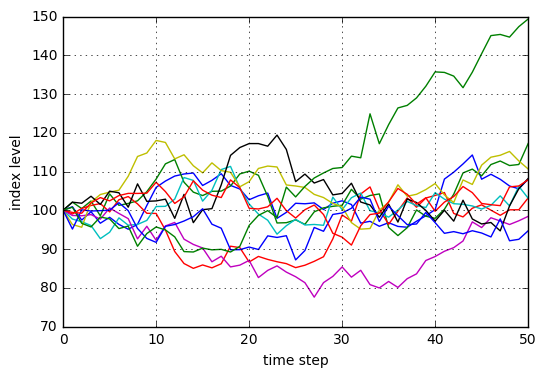

In [112]:
plt.plot(S[:,:10])
plt.grid(True)
plt.xlabel('time step')
plt.ylabel('index level')

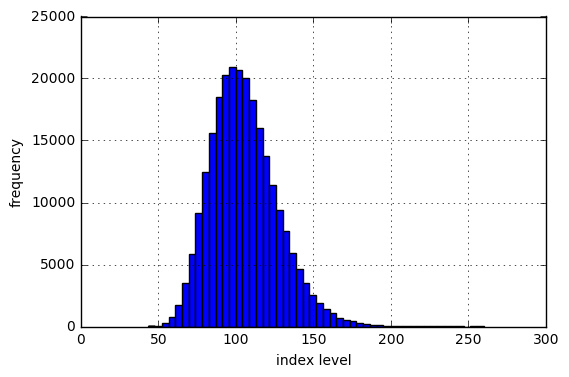

In [114]:
plt.hist(S[-1],bins=50)
plt.grid(True)
plt.xlabel('index level')
plt.ylabel('frequency')

(0, 50000)

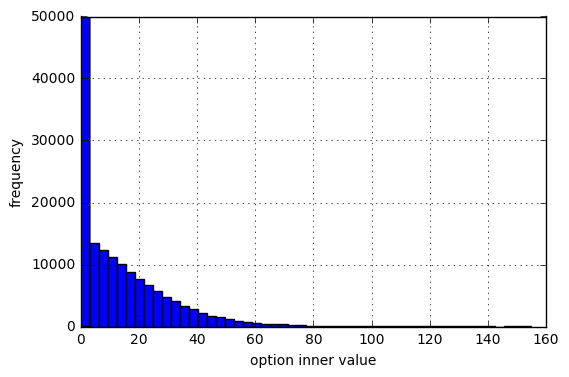

In [116]:
plt.hist(np.maximum(S[-1]-K,0),bins=50)
plt.grid(True)
plt.xlabel('option inner value')
plt.ylabel('frequency')
plt.ylim(0,50000)

In [117]:
sum(S[-1]<K)

133533

# 3.Technical Analysis

In [120]:
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import datetime

In [122]:
sp500=web.DataReader('^GSPC',data_source='yahoo',start='1/1/2000',end='4/14/2014')

In [123]:
sp500.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3592 entries, 2000-01-03 to 2014-04-14
Data columns (total 6 columns):
Open         3592 non-null float64
High         3592 non-null float64
Low          3592 non-null float64
Close        3592 non-null float64
Volume       3592 non-null int64
Adj Close    3592 non-null float64
dtypes: float64(5), int64(1)
memory usage: 196.4 KB


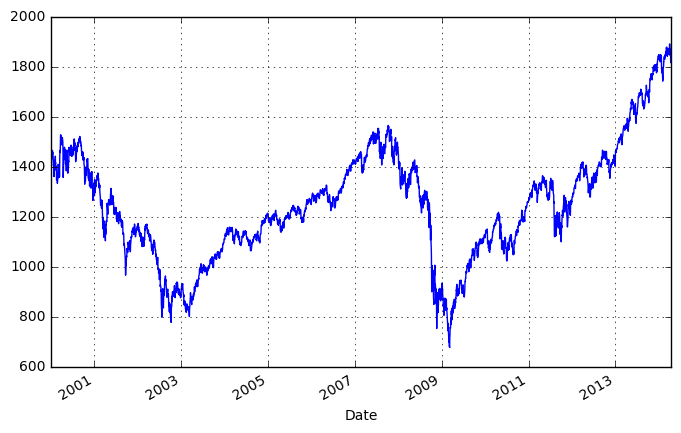

In [124]:
sp500['Close'].plot(grid=True,figsize=(8,5))

In [130]:
sp500['42d']=np.round(sp500['Close'].rolling(window=42,center=False).mean(),2)
sp500['252d']=np.round(sp500['Close'].rolling(window=252,center=False).mean(),2)

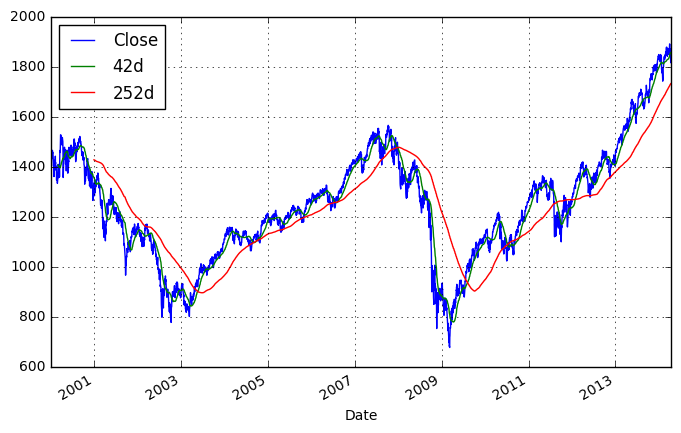

In [132]:
sp500[['Close','42d','252d']].plot(grid=True,figsize=(8,5))

In [133]:
sp500['42-252']=sp500['42d']-sp500['252d']

In [140]:
SD=50
sp500['Regime']=np.where(sp500['42-252']>SD,1,0)
sp500['Regime']=np.where(sp500['42-252']<-SD,-1,sp500['Regime'])
sp500['Regime'].value_counts()

 1    1489
 0    1232
-1     871
Name: Regime, dtype: int64

(-1.1, 1.1)

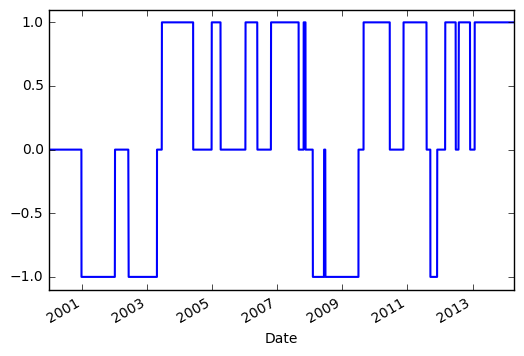

In [142]:
sp500['Regime'].plot(lw=1.5)
plt.ylim([-1.1,1.1])

In [143]:
sp500['Market']=np.log(sp500['Close']/sp500['Close'].shift(1))

In [145]:
sp500['Strategy']=sp500['Regime'].shift(1)*sp500['Market']

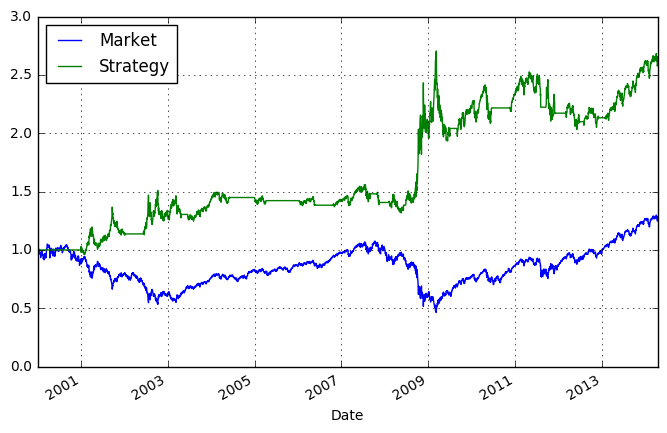

In [148]:
sp500[['Market','Strategy']].cumsum().apply(np.exp).plot(grid=True,figsize=(8,5))